In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cpi
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm
from sklearn.metrics import mean_squared_error
from math import sqrt
import scipy
import statsmodels
from datetime import date
from methods import adf_test

In [2]:
# --------------------------- Select Data via API ---------------------------
msft = yf.Ticker("MSFT")
# display stock info
msft.info


{'address1': 'One Microsoft Way',
 'city': 'Redmond',
 'state': 'WA',
 'zip': '98052-6399',
 'country': 'United States',
 'phone': '425 882 8080',
 'website': 'https://www.microsoft.com',
 'industry': 'Software - Infrastructure',
 'industryKey': 'software-infrastructure',
 'industryDisp': 'Software - Infrastructure',
 'sector': 'Technology',
 'sectorKey': 'technology',
 'sectorDisp': 'Technology',
 'longBusinessSummary': "Microsoft Corporation develops and supports software, services, devices, and solutions worldwide. The company's Productivity and Business Processes segment offers Microsoft 365 Commercial, Enterprise Mobility + Security, Windows Commercial, Power BI, Exchange, SharePoint, Microsoft Teams, Security and Compliance, and Copilot; Microsoft 365 Commercial products, such as Windows Commercial on-premises and Office licensed services; Microsoft 365 Consumer products and cloud services, such as Microsoft 365 Consumer subscriptions, Office licensed on-premises, and other consu

In [3]:
# download the dow jones and microsoft data together
data = yf.download(["MSFT", "^DJI"], start="2010-01-01",
                    end="2024-01-01")
data


[*********************100%***********************]  2 of 2 completed


Price            Close                      High                       Low  \
Ticker            MSFT          ^DJI        MSFT          ^DJI        MSFT   
Date                                                                         
2010-01-04   23.130053  10583.959961   23.242153  10604.969727   22.861011   
2010-01-05   23.137527  10572.019531   23.242156  10584.559570   22.898380   
2010-01-06   22.995543  10573.679688   23.227216  10594.990234   22.808708   
2010-01-07   22.756392  10606.860352   22.943226  10612.370117   22.562084   
2010-01-08   22.913328  10618.190430   23.077742  10619.400391   22.599447   
...                ...           ...         ...           ...         ...   
2023-12-22  369.077118  37385.968750  369.668309  37534.519531  367.234594   
2023-12-26  369.155914  37545.328125  371.402418  37617.988281  368.012952   
2023-12-27  368.574615  37656.519531  369.550062  37683.699219  367.333116   
2023-12-28  369.766815  37710.101562  370.929473  37778.851562  368.663274   
2023-12-29  370.515686  37689.539062  371.619228  37759.429688  367.993297   

Price                           Open                  Volume             
Ticker              ^DJI        MSFT          ^DJI      MSFT       ^DJI  
Date                                                                     
2010-01-04  10430.690430   22.883432  10430.690430  38409100  179780000  
2010-01-05  10522.519531   23.055321  10584.559570  49749600  188540000  
2010-01-06  10546.549805   23.077749  10564.719727  58182400  186040000  
2010-01-07  10505.209961   22.890911  10571.110352  50559700  217390000  
2010-01-08  10554.330078   22.629341  10606.400391  51197400  172710000  
...                  ...         ...           ...       ...        ...  
2023-12-22  37268.878906  368.190346  37349.269531  17107500  252970000  
2023-12-26  37371.828125  369.490916  37405.898438  12673100  212420000  
2023-12-27  37488.601562  368.200193  37518.621094  14905400  245530000  
2023-12-28  37650.980469  369.855489  37661.519531  14327000  199550000  
2023-12-29  37538.800781  370.476265  37701.628906  18730800  234570000  

[3522 rows x 10 columns]

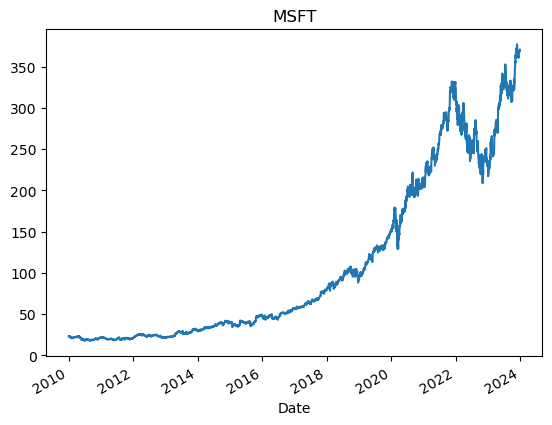

In [4]:
# --------------------------- Preview Data Graphically ---------------------------
data.Close.MSFT.plot(title="MSFT");

<Axes: title={'center': '^DJI'}, xlabel='Date'>

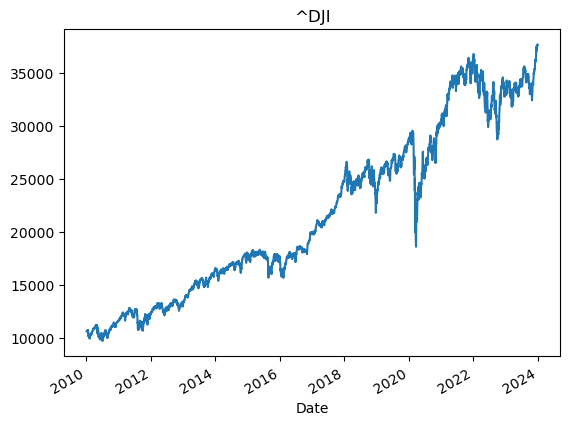

In [5]:
data.Close['^DJI'].plot(title="^DJI")

In [6]:
cpi.update()
close = data.Close.copy()
close.rename(columns={"^DJI" : "DJI"}, inplace=True)
close

C:\Users\s4gen\anaconda3\Lib\site-packages\cpi\download.py:175: DtypeWarning: Columns (3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(io.StringIO(response.text), sep="\t")
C:\Users\s4gen\anaconda3\Lib\site-packages\cpi\download.py:175: DtypeWarning: Columns (3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(io.StringIO(response.text), sep="\t")
C:\Users\s4gen\anaconda3\Lib\site-packages\cpi\download.py:175: DtypeWarning: Columns (3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(io.StringIO(response.text), sep="\t")
C:\Users\s4gen\anaconda3\Lib\site-packages\cpi\download.py:175: DtypeWarning: Columns (3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(io.StringIO(response.text), sep="\t")


Ticker,MSFT,DJI
Date,,
2010-01-04,23.130053,10583.959961
2010-01-05,23.137527,10572.019531
2010-01-06,22.995543,10573.679688
2010-01-07,22.756392,10606.860352
2010-01-08,22.913328,10618.190430
...,...,...
2023-12-22,369.077118,37385.968750
2023-12-26,369.155914,37545.328125
2023-12-27,368.574615,37656.519531


In [7]:
#isolation of the unique months in the data
date_range = pd.date_range(close.index[0] - pd.DateOffset(days=3),
                           close.index[-1], freq="MS")
date_range

DatetimeIndex(['2010-01-01', '2010-02-01', '2010-03-01', '2010-04-01',
               '2010-05-01', '2010-06-01', '2010-07-01', '2010-08-01',
               '2010-09-01', '2010-10-01',
               ...
               '2023-03-01', '2023-04-01', '2023-05-01', '2023-06-01',
               '2023-07-01', '2023-08-01', '2023-09-01', '2023-10-01',
               '2023-11-01', '2023-12-01'],
              dtype='datetime64[ns]', length=168, freq='MS')

In [8]:
cpi_mon = pd.DataFrame(index=date_range)
cpi_mon.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 168 entries, 2010-01-01 to 2023-12-01
Freq: MS
Empty DataFrame


In [9]:
cpi_202301 = cpi.get(date(2023,1,1))
cpi_202301


299.17

In [10]:
cpi_mon['factor'] = cpi_mon.index.map(lambda x: cpi_202301 / cpi.get(x.date()))
cpi_mon

,factor
2010-01-01,1.380655
2010-02-01,1.380311
2010-03-01,1.374666
2010-04-01,1.372283
2010-05-01,1.371220
...,...
2023-08-01,0.974413
2023-09-01,0.971997
2023-10-01,0.972370
2023-11-01,0.974333


In [11]:
close['factor'] = close.index.to_period('M').map(cpi_mon.factor.to_period('M').to_dict())
close

Ticker,MSFT,DJI,factor
Date,,,
2010-01-04,23.130053,10583.959961,1.380655
2010-01-05,23.137527,10572.019531,1.380655
2010-01-06,22.995543,10573.679688,1.380655
2010-01-07,22.756392,10606.860352,1.380655
2010-01-08,22.913328,10618.190430,1.380655
...,...,...,...
2023-12-22,369.077118,37385.968750,0.975302
2023-12-26,369.155914,37545.328125,0.975302
2023-12-27,368.574615,37656.519531,0.975302


In [12]:
#inflate set of time series
cols = ["MSFT", "DJI"]
for col in cols:
    close[f'{col}_scaled'] = close[col] * close.factor
close

Ticker,MSFT,DJI,factor,MSFT_scaled,DJI_scaled
Date,,,,,
2010-01-04,23.130053,10583.959961,1.380655,31.934624,14612.797729
2010-01-05,23.137527,10572.019531,1.380655,31.944944,14596.312115
2010-01-06,22.995543,10573.679688,1.380655,31.748912,14598.604218
2010-01-07,22.756392,10606.860352,1.380655,31.418727,14644.415269
2010-01-08,22.913328,10618.190430,1.380655,31.635402,14660.058198
...,...,...,...,...,...
2023-12-22,369.077118,37385.968750,0.975302,359.961667,36462.611643
2023-12-26,369.155914,37545.328125,0.975302,360.038517,36618.035166
2023-12-27,368.574615,37656.519531,0.975302,359.471575,36726.480372


<Axes: xlabel='Date'>

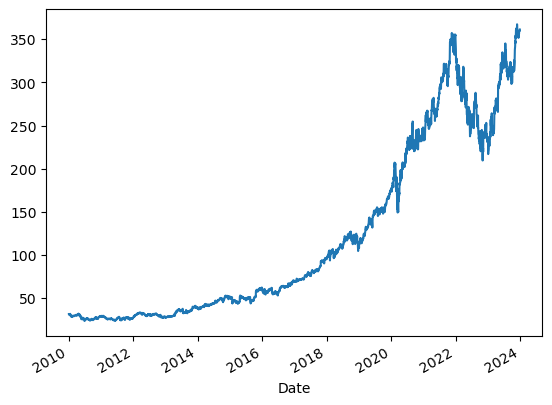

In [13]:
# scaled data inspection
close.MSFT_scaled.plot()

<Axes: xlabel='Date'>

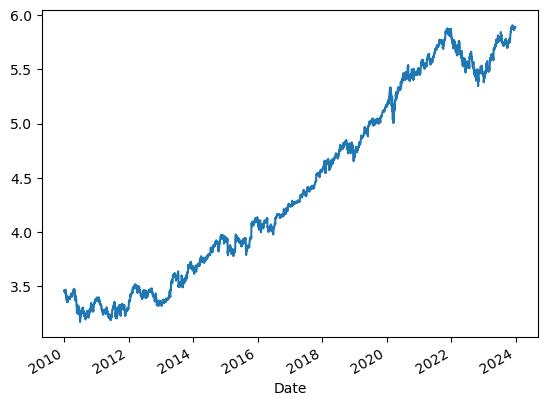

In [14]:
# in its logarithmic form
np.log(close.MSFT_scaled).plot()

<Axes: xlabel='Date'>

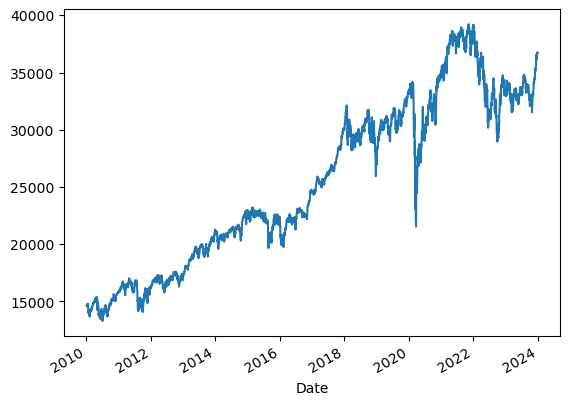

In [15]:
close.DJI_scaled.plot()

In [16]:
# --------------------------- Data Pre-Processing ---------------------------
# resampling data to a mothly frequency to reduce noise and computational load
# create a train-test split - train with data up to 2023, and test on the remaining data.
close.info()

split_date = '2023-01-01'

train_data = close[:split_date]

test_data = close[split_date:]

print(f'Training data length: {len(train_data)}')
print(f'Testing Data Length: {len(test_data)}')

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3522 entries, 2010-01-04 to 2023-12-29
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MSFT         3522 non-null   float64
 1   DJI          3522 non-null   float64
 2   factor       3522 non-null   float64
 3   MSFT_scaled  3522 non-null   float64
 4   DJI_scaled   3522 non-null   float64
dtypes: float64(5)
memory usage: 165.1 KB
Training data length: 3272
Testing Data Length: 250


In [17]:
# --------------------------- Test for Stationarity ---------------------------
# Use ADF tests and explore autocorrelation
adf_test(train_data['MSFT'], 'Adjusted Stock Price')
adf_test(train_data['DJI'], 'Adjusted Index Price')


Augmented Dickey-Fuller Test: Adjusted Stock Price
ADF Statistic              0.256343
p-value                    0.975250
Lags Used                 15.000000
Observations Used       3256.000000
Critical Value (1%)       -3.432360
Critical Value (5%)       -2.862428
Critical Value (10%)      -2.567243

Augmented Dickey-Fuller Test: Adjusted Index Price
ADF Statistic             -0.607188
p-value                    0.869350
Lags Used                 10.000000
Observations Used       3261.000000
Critical Value (1%)       -3.432357
Critical Value (5%)       -2.862427
Critical Value (10%)      -2.567242



In [18]:
# ADF test on logged stock data
adf_test(np.log(train_data['MSFT']), 'Adjusted Stock Price')
adf_test(np.log(train_data['DJI']), "Adjusted Index Price")

Augmented Dickey-Fuller Test: Adjusted Stock Price
ADF Statistic              0.218953
p-value                    0.973305
Lags Used                  9.000000
Observations Used       3262.000000
Critical Value (1%)       -3.432356
Critical Value (5%)       -2.862426
Critical Value (10%)      -2.567242

Augmented Dickey-Fuller Test: Adjusted Index Price
ADF Statistic             -1.043679
p-value                    0.737002
Lags Used                 27.000000
Observations Used       3244.000000
Critical Value (1%)       -3.432367
Critical Value (5%)       -2.862431
Critical Value (10%)      -2.567244



In [19]:
# perform ADF test on logged & differenced stock data
adf_test(np.log(train_data['MSFT']).diff(), "Adjusted Stock Price")
adf_test(np.log(train_data['DJI']).diff(), "Adjusted Index Price")

Augmented Dickey-Fuller Test: Adjusted Stock Price
ADF Statistic            -20.566122
p-value                    0.000000
Lags Used                  8.000000
Observations Used       3262.000000
Critical Value (1%)       -3.432356
Critical Value (5%)       -2.862426
Critical Value (10%)      -2.567242

Augmented Dickey-Fuller Test: Adjusted Index Price
ADF Statistic          -1.218842e+01
p-value                 1.302544e-22
Lags Used               2.600000e+01
Observations Used       3.244000e+03
Critical Value (1%)    -3.432367e+00
Critical Value (5%)    -2.862431e+00
Critical Value (10%)   -2.567244e+00



In [20]:
# perform ADF test on logged returns of stock data
#   Returns are the ratio of adjacent observations

adf_test(np.log(train_data['MSFT'] / train_data['MSFT'].shift(1)), 'Adjusted Stock Price')
adf_test(np.log(train_data['DJI'] / train_data['DJI'].shift(1)), 'Adjusted Stock Price')

Augmented Dickey-Fuller Test: Adjusted Stock Price
ADF Statistic            -20.566122
p-value                    0.000000
Lags Used                  8.000000
Observations Used       3262.000000
Critical Value (1%)       -3.432356
Critical Value (5%)       -2.862426
Critical Value (10%)      -2.567242

Augmented Dickey-Fuller Test: Adjusted Stock Price
ADF Statistic          -1.218842e+01
p-value                 1.302544e-22
Lags Used               2.600000e+01
Observations Used       3.244000e+03
Critical Value (1%)    -3.432367e+00
Critical Value (5%)    -2.862431e+00
Critical Value (10%)   -2.567244e+00



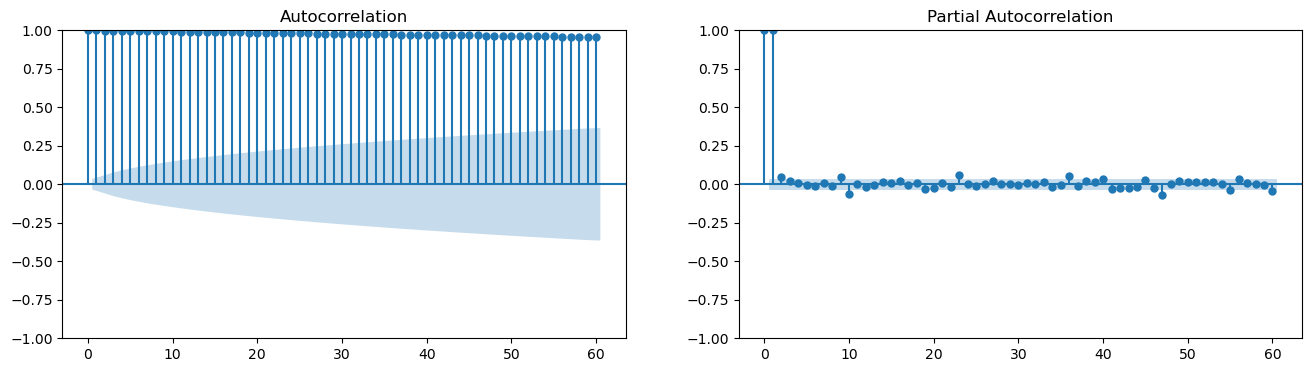

In [21]:
# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(16,4))
a = plot_acf(train_data['MSFT'].dropna(), lags=60, ax=axes[0])
b = plot_pacf(train_data['MSFT'].dropna(), lags=60, ax=axes[1])


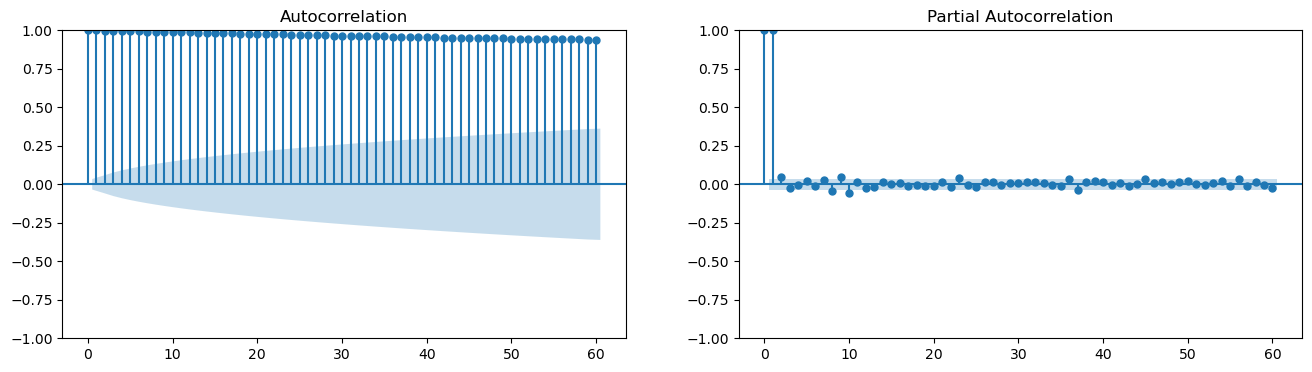

In [22]:
fig, axes = plt.subplots(1,2,figsize=(16,4))
a = plot_acf(train_data['DJI'].dropna(), lags=60, ax=axes[0])
b = plot_pacf(train_data['DJI'].dropna(), lags=60, ax=axes[1])

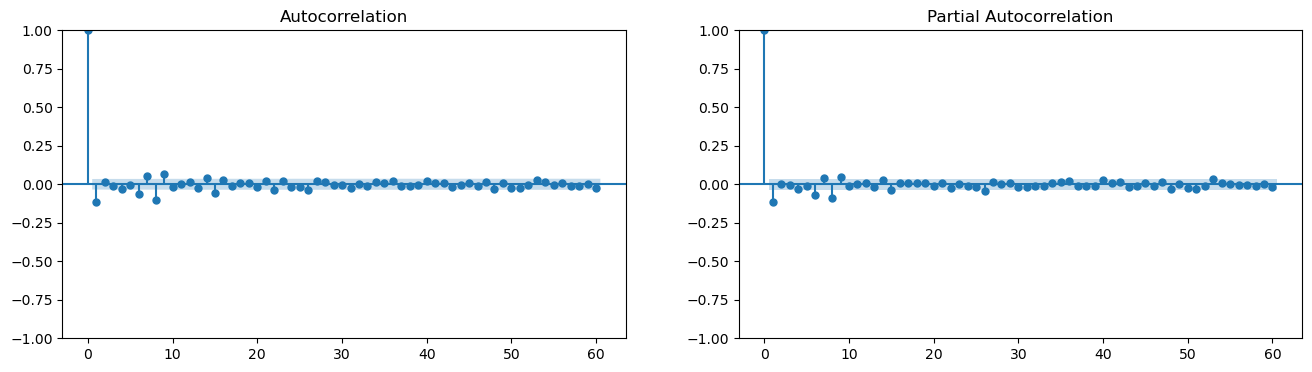

In [23]:
fig, axes = plt.subplots(1,2, figsize=(16,4))
a = plot_acf(np.log(train_data['MSFT'] / train_data['MSFT'].shift(1)).dropna(), lags=60, ax=axes[0])
b = plot_pacf(np.log(train_data['MSFT'] / train_data['MSFT'].shift(1)).dropna(), lags=60, ax=axes[1])


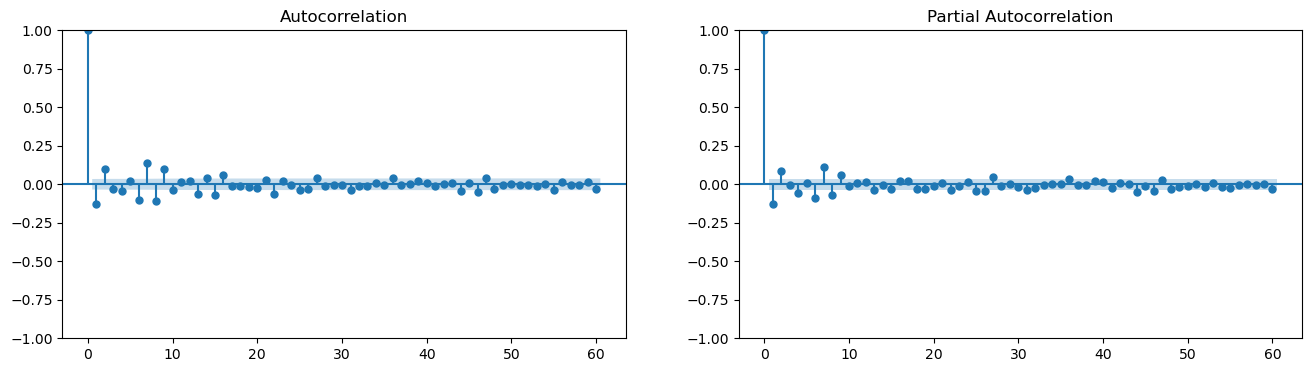

In [24]:
fig, axes = plt.subplots(1,2, figsize=(16,4))
a = plot_acf(np.log(train_data['DJI'] / train_data['DJI'].shift(1)).dropna(), lags=60, ax=axes[0])
b = plot_pacf(np.log(train_data['DJI'] / train_data['DJI'].shift(1)).dropna(), lags=60, ax=axes[1])


In [25]:
# --------------------------- Determine SARIMAX Params ---------------------------
# prepare exogenous variables 
exog_train = train_data['DJI_scaled']
exog_test = test_data['DJI_scaled']

auto_model = pm.auto_arima(np.log(train_data['MSFT_scaled']), exogenous=exog_train, seasonal=True,
                           m=5, trace=True, error_action='ignore', suppress_warnings=True)
print(auto_model.summary())

"""
The AIC is a measure of model quality, balancing model fit (log-likelihood) against model complexity 
(number of parameters). 

Lower AIC values indicate better models, assuming the difference is significant.

Rule of Thumb for AIC, as interpreted from **Differences from between one another** (e.g., comparing two version)
∣ΔAIC∣<2: Models are statistically indistinguishable in terms of fit.
         Differences this small may not justify choosing one model over another purely based on AIC.
∣ΔAIC∣>2: A model with a lower AIC is considered significantly better.
∣ΔAIC∣>10: Strong evidence that the model with the lower AIC is much better.

"""

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[5] intercept   : AIC=-17648.636, Time=1.26 sec
 ARIMA(0,1,0)(0,0,0)[5] intercept   : AIC=-17612.635, Time=0.28 sec
 ARIMA(1,1,0)(1,0,0)[5] intercept   : AIC=-17650.644, Time=0.52 sec
 ARIMA(0,1,1)(0,0,1)[5] intercept   : AIC=-17650.365, Time=0.74 sec
 ARIMA(0,1,0)(0,0,0)[5]             : AIC=-17610.077, Time=0.13 sec
 ARIMA(1,1,0)(0,0,0)[5] intercept   : AIC=-17652.432, Time=0.21 sec
 ARIMA(1,1,0)(0,0,1)[5] intercept   : AIC=-17651.100, Time=0.56 sec
 ARIMA(1,1,0)(1,0,1)[5] intercept   : AIC=-17650.379, Time=0.77 sec
 ARIMA(2,1,0)(0,0,0)[5] intercept   : AIC=-17650.471, Time=0.40 sec
 ARIMA(1,1,1)(0,0,0)[5] intercept   : AIC=-17650.475, Time=0.43 sec
 ARIMA(0,1,1)(0,0,0)[5] intercept   : AIC=-17651.725, Time=0.25 sec
 ARIMA(2,1,1)(0,0,0)[5] intercept   : AIC=-17648.455, Time=0.87 sec
 ARIMA(1,1,0)(0,0,0)[5]             : AIC=-17648.723, Time=0.08 sec

Best model:  ARIMA(1,1,0)(0,0,0)[5] intercept
Total fit time: 6.506 seco

'\nThe AIC is a measure of model quality, balancing model fit (log-likelihood) against model complexity \n(number of parameters). \n\nLower AIC values indicate better models, assuming the difference is significant.\n\nRule of Thumb for AIC, as interpreted from **Differences from between one another** (e.g., comparing two version)\n∣ΔAIC∣<2: Models are statistically indistinguishable in terms of fit.\n         Differences this small may not justify choosing one model over another purely based on AIC.\n∣ΔAIC∣>2: A model with a lower AIC is considered significantly better.\n∣ΔAIC∣>10: Strong evidence that the model with the lower AIC is much better.\n\n'

In [26]:
# --------------------------- Fit the SARIMAX Model ---------------------------
# extract theg best params
order = auto_model.order
seasonal_order = auto_model.seasonal_order

# fit the SARIMAX model
sarimax_model = SARIMAX(np.log(train_data['MSFT_scaled']),
                        exog=exog_train,
                        order=order,
                        seasonal_order=seasonal_order,
                        trend='ct') # Adding the constant (intercept) and trend consideration helps performance
sarimax_results = sarimax_model.fit(method='powell') # changing the solver method from the default aids convergence
print(sarimax_results.summary())

C:\Users\s4gen\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\s4gen\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Optimization terminated successfully.
         Current function value: -3.031399
         Iterations: 1
         Function evaluations: 57
                               SARIMAX Results                                
Dep. Variable:            MSFT_scaled   No. Observations:                 3272
Model:               SARIMAX(1, 1, 0)   Log Likelihood                9918.737
Date:                Sun, 04 Jan 2026   AIC                         -19827.474
Time:                        19:47:36   BIC                         -19797.010
Sample:                             0   HQIC                        -19816.564
                               - 3272                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   4.276e-05      0.000      0.100      0.920      -0.001      

C:\Users\s4gen\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\s4gen\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


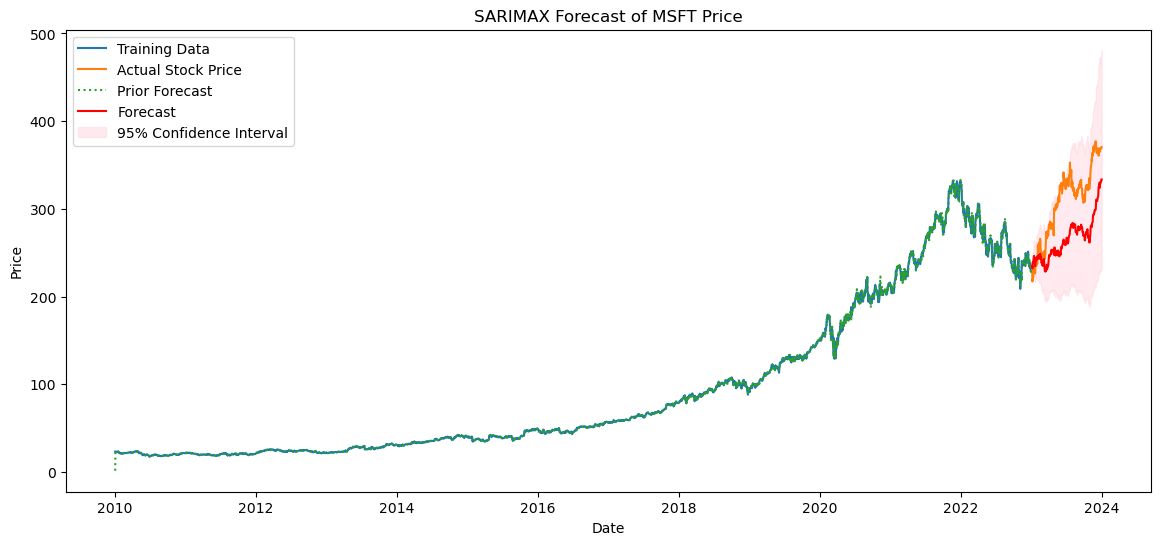

In [27]:
# --------------------------- Forecast Future Stock Prices ---------------------------
n_periods = len(test_data)
forecast = sarimax_results.get_forecast(steps=n_periods, exog=exog_test)
forecast_mean = np.exp(forecast.predicted_mean)/test_data.factor.values
confidence_intervals = forecast.conf_int()
lower_limits = np.exp(confidence_intervals.loc[:, 'lower MSFT_scaled'])/test_data.factor.values
upper_limits = np.exp(confidence_intervals.loc[:, 'upper MSFT_scaled'])/test_data.factor.values

#store results
forecast_dates = test_data.index
forecast_df = pd.DataFrame({
    'Forecast': forecast_mean.values,
    'Lower CI': lower_limits.values,
    'Upper CI': upper_limits.values,
    'Actual': test_data['MSFT'].values 
}, index=forecast_dates)

# plotting

plt.figure(figsize=(14,6))
plt.plot(train_data.index, train_data['MSFT'], label='Training Data')
plt.plot(test_data.index, test_data['MSFT'], label='Actual Stock Price')
plt.plot(train_data.index, np.exp(sarimax_results.fittedvalues)/train_data.factor, ':',
         label='Prior Forecast')
plt.plot(forecast_df.index, forecast_df['Forecast'], label='Forecast', color='red')
plt.fill_between(forecast_df.index, forecast_df['Lower CI'], forecast_df['Upper CI'],
         color='pink', alpha=0.3, label='95% Confidence Interval')
plt.title('SARIMAX Forecast of MSFT Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend();

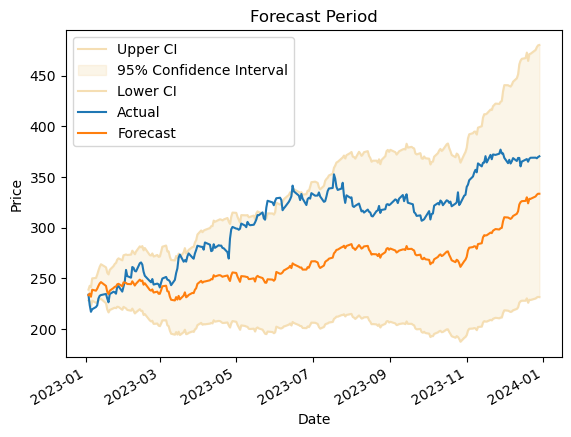

In [28]:
# Examine the forecast period
forecast_df['Upper CI'].plot(color='wheat', title='Forecast Period')
plt.fill_between(
    forecast_df.index,
    forecast_df['Lower CI'],
    forecast_df['Upper CI'],
    alpha = 0.3,
    color='wheat',
    label='95% Confidence Interval'
)
forecast_df['Lower CI'].plot(color='wheat')
forecast_df.Actual.plot(label='Actual')
forecast_df.Forecast.plot()
plt.legend()
plt.ylabel('Price');

In [29]:
# statistics
rmse = sqrt(mean_squared_error(test_data['MSFT'], forecast_df['Forecast']))
print(f'RMSE: {rmse}')


RMSE: 49.002132819609294


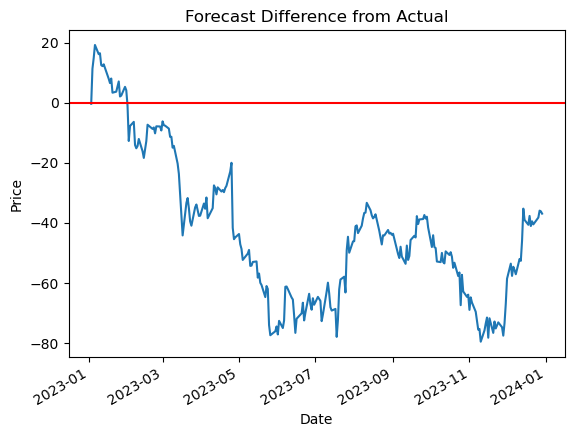

In [30]:
# inspect values
forecast_df['Diff'] = forecast_df.Forecast - forecast_df.Actual
forecast_df
forecast_df['Diff'].plot(title='Forecast Difference from Actual')
plt.axhline(y=0, color='r')
plt.ylabel('Price');


In [31]:
jan_2023 = test_data.loc['2023-01-31']
jan_forecast = forecast_df.loc['2023-01-31']

print(f'Actual Price (January 2023): {jan_2023['MSFT']}')
print(f'Forecasted Price (January 2023): {jan_forecast['Forecast']}')


Actual Price (January 2023): 242.02345275878906
Forecasted Price (January 2023): 246.15969482803544


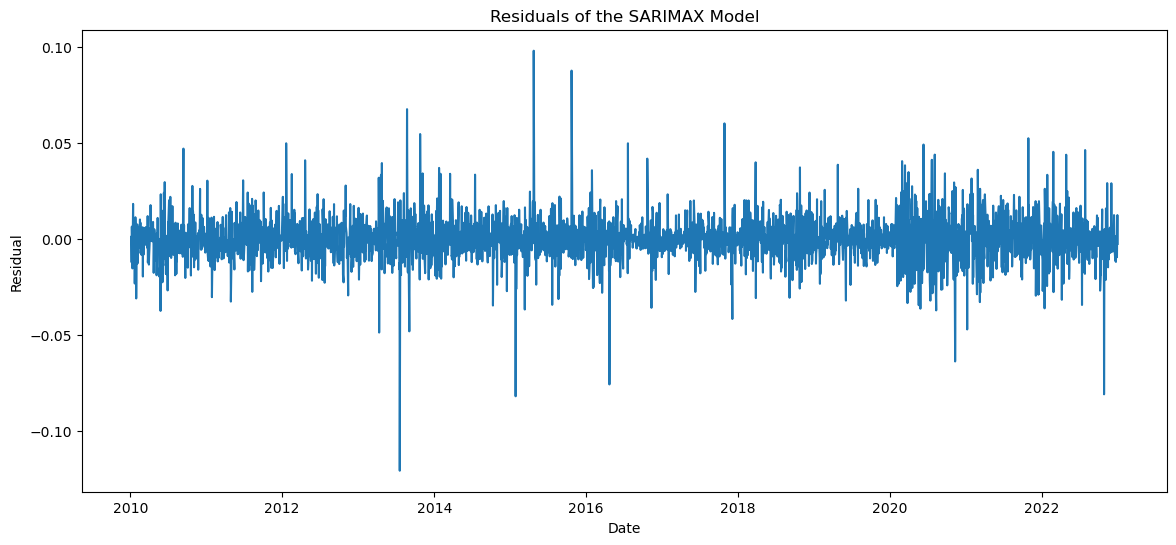

In [32]:
# inspect the residuals
resids = sarimax_results.resid[1:]
plt.figure(figsize=(14, 6))
plt.plot(resids)
plt.title('Residuals of the SARIMAX Model')
plt.xlabel('Date')
plt.ylabel('Residual');

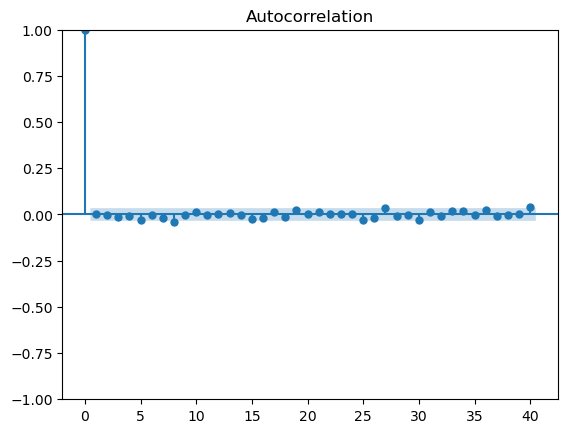

In [33]:
# plot acf residuals
plot_acf(resids.dropna(), lags=40)
plt.show()

'\nThis model rather dramatically misses the extremes.\n\nIt predicts the mean reasonably well, but the model is not\ngoing to capture large moves in this stock.\n\nAt the same time, because the errors are not behaving normally,\nany uncertainty estimates are likely to be unreliable.\n\nWe would be interested to determine whether the large residual \nspikes correspond to known events in the time series.\n'

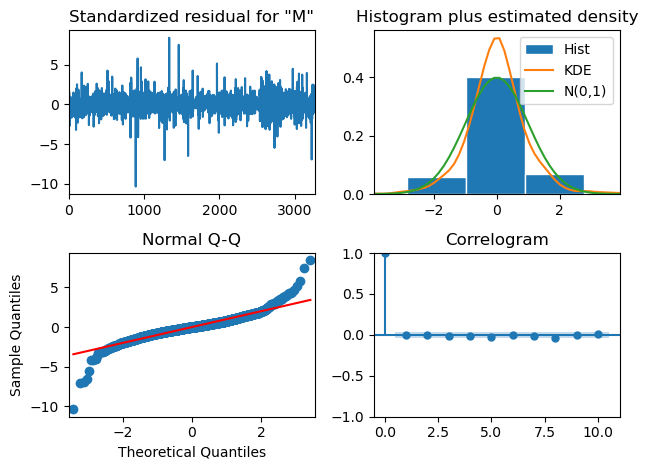

In [34]:
sarimax_results.plot_diagnostics()
plt.tight_layout()

"""
This model rather dramatically misses the extremes.

It predicts the mean reasonably well, but the model is not
going to capture large moves in this stock.

At the same time, because the errors are not behaving normally,
any uncertainty estimates are likely to be unreliable.

We would be interested to determine whether the large residual 
spikes correspond to known events in the time series.
"""